<center><h1> Named Entity Recoginition</h1></center>
<h4><center>
Yadi Li<br>
12/14/2017</center></h4>

- ** Natural language processing **<br>
	programming computers to fruitfully process large natural language data <br>
- ** What Is Named Entity Recognition(NER)? **<br>
	Jim bought 300 shares of Acme Corp. in 2006. <br>
	$[Jim]_{Person}$ bought 300 shares of $[Acme Corp.]_{Organization}$ in $[2006]_{Time}$. <br>
- ** Why NER? ** <br>
    extraction from journalistic articles<br>
    molecular biology, bioinformatics, and medical natural language processing communities. genes and gene products.


## Workflow
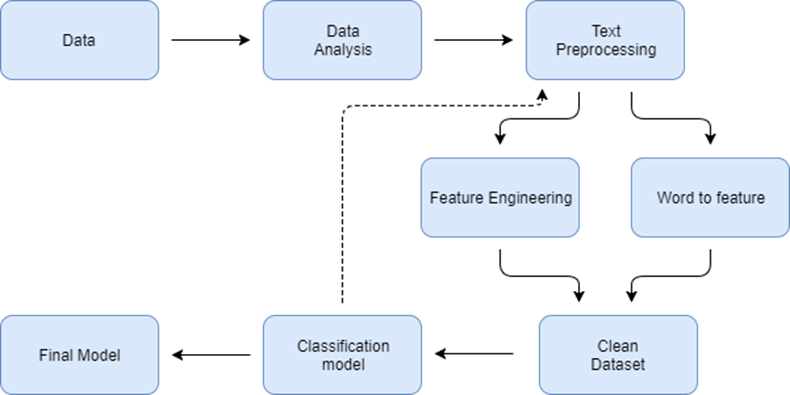

In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import multiprocessing
import gensim
from gensim.models import Word2Vec
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict,OrderedDict,Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
# pd.set_option("display.max_rows",20)

C:\Users\liyad\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### load the data into dataframe

This part should work (worked on the computer when I initially write the notebook, but raised error on a different computer)

In [2]:
# read tab separated file into list
lst = []
with open('dataset_22nov17.txt') as f:
    for line in f:
        lst.append(line.replace('\n','').split('\t'))

# creat pandas dataframe
df = pd.DataFrame(lst[1:],columns=lst[0])
df.drop('', axis=1,inplace=True)                                          # remove duplicated index column
df['Sentence #'] = pd.to_numeric(df['Sentence #'], downcast='integer')    # convert value from str to int
df

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O
5,1,through,IN,O
6,1,London,NNP,B-geo
7,1,to,TO,O
8,1,protest,VB,O
9,1,the,DT,O


Had some encoding issue on one of my computer, and used code below instead

In [3]:
# df = pd.read_csv('dataset_22nov17.txt', delimiter='\t', encoding='cp1252')
# df.drop('Unnamed: 0', axis=1,inplace=True)                                # remove duplicated index column
# df['Sentence #'] = pd.to_numeric(df['Sentence #'], downcast='integer')    # convert value from str to int
# df

In [4]:
# just to check some example sentences
for i in range(100,110):
    print(' '.join(df['Word'][df['Sentence #']==i]))

Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .
The Pakistani military launched its offensive in Orakzai to hunt Taliban insurgents .
So far , nearly 100 militants have been reported killed in the region since Thursday .
On Friday , five soldiers were killed when dozens of militants stormed a military checkpoint in Orakzai .
At least 32 suspected militants were killed when troops launched a counter-attack .
Elsewhere in the northwest , authorities on Saturday found the bodies of six people who had been shot dead in the Kurram region along the Afghan border .
The six were kidnapped a few days ago .
The U.S. military in Afghanistan says coalition forces killed 14 Taleban militants in separate clashes this week .
The military said Saturday 13 guerrillas were killed in two encounters in the central province of Uruzgan .
One Afghan 

### some EDA

In [5]:
print('Total sentences: {}'.format(max(df['Sentence #'])))
print('Total words: {}'.format(df.shape[0]))
print('Size of vocabulary: {}'.format(len(set(df.Word))))
print('Total POS tags: {}'.format(len(set(df.POS))))
print('Total entity tags: {}'.format(len(set(df.Tag))))
print('Total words tagged as named entity: {}'.format(sum(df.Tag!='O')))
print('Total number of named entities: {}'.format(len(set(df.Word[df.Tag!='O']))))

Total sentences: 2999
Total words: 66161
Size of vocabulary: 8766
Total POS tags: 41
Total entity tags: 17
Total words tagged as named entity: 9944
Total number of named entities: 2418


In [6]:
# any missing value?
df.isnull().any()

Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool

In [7]:
df.Tag.value_counts()

O        56217
B-geo     2070
B-org     1237
I-per     1234
B-gpe     1230
B-tim     1160
B-per     1107
I-org      926
I-geo      414
I-tim      334
B-art       53
B-eve       45
I-eve       37
I-art       34
I-gpe       34
B-nat       20
I-nat        9
Name: Tag, dtype: int64

In [8]:
pd.set_option("display.max_rows",50)
contingency_table = pd.crosstab(index=df.POS, columns=df.Tag)
contingency_table

Tag,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
POS,,,,,,,,,,,,,,,,,
$,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61
",",0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,10,1940
.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2992
:,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,6,45
;,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
CC,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,14,1437
CD,0,2,2,0,0,0,0,225,1,0,0,0,0,1,0,158,1085
DT,1,0,14,0,0,12,0,7,1,0,0,0,0,0,0,0,6275
EX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43


In [9]:
pos_filter = list(contingency_table.index[(contingency_table.iloc[:, :-1]==0).all(1)])
print('POS that are not named entity: ')
print(*pos_filter)

POS that are not named entity: 
$ . ; EX JJS LRB MD PDT PRP RBS RP RRB UH VBD VBG VBP VBZ WDT WP WP$ WRB


In [10]:
pd.set_option("display.max_rows",20)

### some initial thought:
- imbalanced data. verbs are not tagged as named entities <br>
- Tags like natural phenomenon have very little samples 
- Most of the named entities are from words tagged JJ, NNP or CD as POS tag.  <br>
- time and organization are probably harder to classify than other tags as they can be word with a range of POS tags <br>

for my reference: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

### Feature engineering 
- is_capitalized
- abbr_upper
- stemming 
- implementation of n-gram
- position_in_sent

In [11]:
# some functions for generating features

# many named entities are capitalized
def is_capitalized(word):
    return word[0].isupper()

# abbreviation or all uppercase, example: US, U.S.
def abbr_upper(word):
    return all([c.isupper() for c in word]) or re.search('^([a-zA-Z]\.)+$', word)!=None


# to lower and reduce to the base form
stemmer = SnowballStemmer('english')
def lemma(word):
    return stemmer.stem(word)

# next word
def next_word():
    lst = defaultdict(list)
    for i in range(1,3000):
        word = list(df['Word'][df['Sentence #']==i]) + ['-End1-']
        lemma = list(df['lemma'][df['Sentence #']==i]) + ['-End1-']
        pos = list(df['POS'][df['Sentence #']==i]) + ['-End1-']
        lst['next_word'].extend(word[1:])
        lst['next_lemma'].extend(lemma[1:])
        lst['next_pos'].extend(pos[1:])
    return lst 

# next-next-word
def next_next_word():
    lst = defaultdict(list)
    for i in range(1,3000):
        word = list(df['Word'][df['Sentence #']==i]) + ['-End1-', '-End2-']
        lemma = list(df['lemma'][df['Sentence #']==i]) + ['-End1-', '-End2-']
        pos = list(df['POS'][df['Sentence #']==i]) + ['-End1-', '-End2-']
        lst['next_next_word'].extend(word[2:])
        lst['next_next_lemma'].extend(lemma[2:])
        lst['next_next_pos'].extend(pos[2:])
    return lst 

# previous word
def prev_word():
    lst = defaultdict(list)
    for i in range(1,3000):
        word = ['-Start1-'] + list(df['Word'][df['Sentence #']==i])
        lemma = ['-Start1-'] + list(df['lemma'][df['Sentence #']==i])
        pos = ['-Start1-'] + list(df['POS'][df['Sentence #']==i])
        lst['prev_word'].extend(word[:-1])
        lst['prev_lemma'].extend(lemma[:-1])
        lst['prev_pos'].extend(pos[:-1])
    return lst 

# prev_prev_word
def prev_prev_word():
    lst = defaultdict(list)
    for i in range(1,3000):
        word = ['-Start2-', '-Start1-'] + list(df['Word'][df['Sentence #']==i])
        lemma = ['-Start2-', '-Start1-'] + list(df['lemma'][df['Sentence #']==i])
        pos = ['-Start2-', '-Start1-'] + list(df['POS'][df['Sentence #']==i])
        lst['prev_prev_word'].extend(word[:-2])
        lst['prev_prev_lemma'].extend(lemma[:-2])
        lst['prev_prev_pos'].extend(pos[:-2])
    return lst 

# may be the position of the word in the sentence could help?
class OrderedCounter(Counter, OrderedDict):
    pass
def position_in_sent():
    lst = []
    sent_len = OrderedCounter(df['Sentence #'])
    for key in sent_len:
        lst.extend([round(i/(sent_len[key]-1),3) for i in range(sent_len[key])])
    return lst

In [12]:
%%time

print('Start generating features...')
df['capitalized'] = list(map(is_capitalized, df.Word))
df['abbr_upper'] = list(map(abbr_upper, df.Word))
df['lemma'] = list(map(lemma, df.Word))
df['next_word'] = next_word()['next_word']
df['next_lemma'] = next_word()['next_lemma']
df['next_pos'] = next_word()['next_pos']
df['prev_word'] = prev_word()['prev_word']
df['prev_lemma'] = prev_word()['prev_lemma']
df['prev_pos'] = prev_word()['prev_pos']
df['next_next_word'] = next_next_word()['next_next_word']
df['next_next_lemma'] = next_next_word()['next_next_lemma']
df['next_next_pos'] = next_next_word()['next_next_pos']
df['prev_prev_word'] = prev_prev_word()['prev_prev_word']
df['prev_prev_lemma'] = prev_prev_word()['prev_prev_lemma']
df['prev_prev_pos'] = prev_prev_word()['prev_prev_pos']
df['position_in_sent'] = position_in_sent()

print('Saving dataframe to csv...')
df.to_csv('fullset.csv')

Start generating features...
Saving dataframe to csv...
Wall time: 1min 23s


In [13]:
df

,Sentence #,Word,POS,Tag,capitalized,abbr_upper,lemma,next_word,next_lemma,next_pos,prev_word,prev_lemma,prev_pos,next_next_word,next_next_lemma,next_next_pos,prev_prev_word,prev_prev_lemma,prev_prev_pos,position_in_sent
0,1,Thousands,NNS,O,True,False,thousand,of,of,IN,-Start1-,-Start1-,-Start1-,demonstrators,demonstr,NNS,-Start2-,-Start2-,-Start2-,0.000
1,1,of,IN,O,False,False,of,demonstrators,demonstr,NNS,Thousands,thousand,NNS,have,have,VBP,-Start1-,-Start1-,-Start1-,0.043
2,1,demonstrators,NNS,O,False,False,demonstr,have,have,VBP,of,of,IN,marched,march,VBN,Thousands,thousand,NNS,0.087
3,1,have,VBP,O,False,False,have,marched,march,VBN,demonstrators,demonstr,NNS,through,through,IN,of,of,IN,0.130
4,1,marched,VBN,O,False,False,march,through,through,IN,have,have,VBP,London,london,NNP,demonstrators,demonstr,NNS,0.174
5,1,through,IN,O,False,False,through,London,london,NNP,marched,march,VBN,to,to,TO,have,have,VBP,0.217
6,1,London,NNP,B-geo,True,False,london,to,to,TO,through,through,IN,protest,protest,VB,marched,march,VBN,0.261
7,1,to,TO,O,False,False,to,protest,protest,VB,London,london,NNP,the,the,DT,through,through,IN,0.304
8,1,protest,VB,O,False,False,protest,the,the,DT,to,to,TO,war,war,NN,London,london,NNP,0.348
9,1,the,DT,O,False,False,the,war,war,NN,protest,protest,VB,in,in,IN,to,to,TO,0.391


**more features like endswith '.' or contain '-' could be added**

## vectorizing columns 
- label encode: save space, but impose unnecessary order/similarity/meanings between words, using tree based model. problematic if the test word is not in the training data
- dummify/onehotencode/dictvectorizer: dose not impose any order/similarity/meanings between words, but result in too many features/dimensions
- word2vec: in principle should be a better solution, but need more data to do so

- to be added: TF-IDF feature

In [14]:
vectorizer = DictVectorizer(sparse=True)
x = vectorizer.fit_transform(df.to_dict("records"))
x.shape

(66161, 73026)

### word2vec 
- not enough text
- stop words, punctuations are not removed

In [15]:
class MySentences(object): 
    def __iter__(self):
        for i in range(1,3000):
            yield list(df['lemma'][df['Sentence #']==i])

In [16]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [17]:
%%time

cores = multiprocessing.cpu_count()-1

if not os.path.exists('models/word2vec.model'):
    print("start traing word2vec model...")
    sentences = MySentences()
    word2vec_model = gensim.models.Word2Vec(sentences, min_count=1, size=50, workers=cores, negative=0, window=5)
    if not os.path.exists('models'):
        os.makedirs('models')
        word2vec_model.save('models/word2vec.model')
    else:
        word2vec_model.save('models/word2vec.model')
else:
    word2vec_model = Word2Vec.load('models/word2vec.model')

Wall time: 62.2 ms


In [18]:
word2vec_model.wv.word_vec('london')

array([-0.00183091, -0.00685674, -0.00994333, -0.00924266,  0.00765945,
        0.00285691,  0.00513288, -0.00902568,  0.00779676,  0.00745726,
        0.00749154, -0.00886141,  0.00434457,  0.00533795,  0.00267692,
        0.00953503, -0.00264016,  0.00809666, -0.00437838,  0.00811244,
       -0.00585993, -0.0081155 ,  0.00193049, -0.00333237, -0.0060479 ,
       -0.00062682,  0.00376872,  0.0009881 ,  0.00941965,  0.006013  ,
        0.0028522 , -0.00402387, -0.00292947,  0.00869808, -0.00358897,
        0.00966131,  0.00567841, -0.00671741, -0.00253384, -0.00234681,
       -0.00023694,  0.00816387, -0.00336444,  0.00729915, -0.00709441,
        0.00110854, -0.0076854 , -0.00417888,  0.00960993,  0.00803149], dtype=float32)

In [19]:
word2vec_model.wv.most_similar(positive=['iraq'], topn=10)

[('pkk', 0.5435799360275269),
 ('maoist', 0.4821608066558838),
 ('idiot', 0.4528745114803314),
 ('hypothermia', 0.436810702085495),
 ('reward', 0.42955487966537476),
 ('worrisom', 0.42453697323799133),
 ('decapit', 0.4221016764640808),
 ('spokesman', 0.41420072317123413),
 ('unchang', 0.410594642162323),
 ('made', 0.40798163414001465)]

### label encoding

In [20]:
Word_le = LabelEncoder()
lemma_le = LabelEncoder()
POS_le = LabelEncoder()
Tag_le = LabelEncoder()

# define function to help lebel encoding
def le_vectorizer(coltype, train_df, df=df):
    colnames = [name for name in df.columns if re.search(coltype.lower()+'$',name.lower())]
    eval(coltype+'_le').fit(list(df[coltype].unique())+(['-Start1-','-Start2-','-End1-','-End2-'] if coltype!='Tag' else []))
    for col in colnames:
        train_df[col] = eval(coltype+'_le').transform(df[col])
    return train_df

In [21]:
train_df = pd.DataFrame()
for coltype in ['Word','lemma','POS','Tag']:
    train_df = le_vectorizer(coltype, train_df)

train_df['capitalized'] = list(map(int, df['capitalized']))
train_df['abbr_upper'] = list(map(int, df['abbr_upper']))
train_df['position_in_sent'] = df['position_in_sent']

train_df

,Word,next_word,prev_word,next_next_word,prev_prev_word,lemma,next_lemma,prev_lemma,next_next_lemma,prev_prev_lemma,POS,next_pos,prev_pos,next_next_pos,prev_prev_pos,Tag,capitalized,abbr_upper,position_in_sent
0,2678,6379,14,4343,15,5516,3927,13,1726,14,22,13,4,22,5,16,1,0,0.000
1,6379,4343,2678,5331,14,3927,1726,5516,2627,13,13,22,22,38,4,16,0,0,0.043
2,4343,5331,6379,6017,2678,1726,2627,3927,3464,5516,22,38,13,37,22,16,0,0,0.087
3,5331,6017,4343,8239,6379,2627,3464,1726,5526,3927,38,37,22,13,13,16,0,0,0.130
4,6017,8239,5331,1747,4343,3464,5526,2627,3350,1726,37,13,38,20,22,16,0,0,0.174
5,8239,1747,6017,8259,5331,5526,3350,3464,5548,2627,13,20,37,32,38,16,0,0,0.217
6,1747,8259,8239,6936,6017,3350,5548,5526,4372,3464,20,32,13,34,37,2,1,0,0.261
7,8259,6936,1747,8195,8239,5548,4372,3350,5487,5526,32,34,20,11,13,16,0,0,0.304
8,6936,8195,8259,8596,1747,4372,5487,5548,5904,3350,34,11,32,19,20,16,0,0,0.348
9,8195,8596,6936,5532,8259,5487,5904,4372,2835,5548,11,19,34,13,32,16,0,0,0.391


## split train test set:
Alternatively, could try to split data by sentence, since this would be what happens in a real test situation. But error was raised while doing cross validation because one(or more) class had less than 5 samples (since it's 5 fold cv).

In [22]:
# import random

# random.seed(2017)
# test_sent = random.sample(range(1,3000), int(2999*0.2))
# train_sent = [idx for idx in range(1,3000) if idx not in test_idx]
# test_idx = [x for x in range(len(df.iloc[:,0])) if df.iloc[x,0] in test_sent]
# train_idx = [x for x in range(len(df.iloc[:,0])) if df.iloc[x,0] in train_sent]

# x_train = train_df.drop('Tag', axis=1).iloc[train_idx,:]
# y_train = train_df['Tag'].iloc[train_idx]
# x_test = train_df.drop('Tag', axis=1).iloc[test_idx,:]
# y_test = train_df['Tag'].iloc[test_idx]

x_full = train_df.drop('Tag', axis=1)
y_full = train_df['Tag']

x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size = 0.2, random_state=2017, stratify=y_full)

## training random forest model

In [23]:
ner = RandomForestClassifier()

grid_para_forest = [{
    'n_estimators': [50, 100],
    'criterion': ['gini'],
    'max_features': list(range(4,9)),
    "random_state": [2017],
    'class_weight': [None, 'balanced']}]
grid_search_forest = GridSearchCV(ner, grid_para_forest, scoring='f1_weighted', cv=5, n_jobs=-1, verbose = 10)

grid_search_forest.fit(x_train, y_train)
grid_search_forest.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


0.93800044816751815

In [24]:
grid_search_forest.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': 5,
 'n_estimators': 100,
 'random_state': 2017}

### Feature importance

In [25]:
ner = RandomForestClassifier(max_features=5, n_estimators=100, random_state=2107)
ner.fit(x_train, y_train)

for name,i in zip(list(x_train.columns),ner.feature_importances_):
    print(name, i)

Word 0.141331792668
next_word 0.0446397615313
prev_word 0.0593332031804
next_next_word 0.0271951669471
prev_prev_word 0.0314966947735
lemma 0.0656632656434
next_lemma 0.0343200915308
prev_lemma 0.0388015407985
next_next_lemma 0.0255101594915
prev_prev_lemma 0.0297438747108
POS 0.153232837861
next_pos 0.0311391104024
prev_pos 0.0546515296516
next_next_pos 0.0216743575465
prev_prev_pos 0.0234249364308
capitalized 0.165483973206
abbr_upper 0.00680572753017
position_in_sent 0.0455519760957


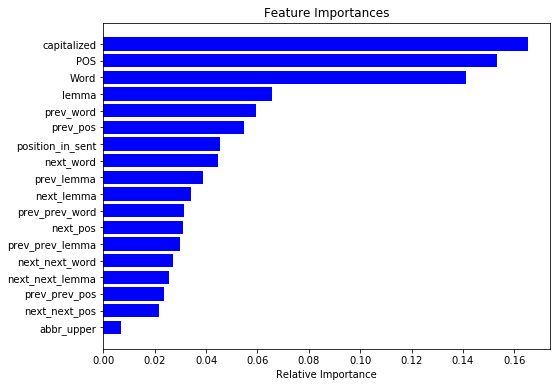

In [26]:
features = x_train.columns.values.tolist()
importances = ner.feature_importances_
ordered_imp = sorted(zip(features, importances), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(ordered_imp)), [imp for f,imp in ordered_imp], color='b', align='center')
plt.yticks(range(len(ordered_imp)), [f for f,imp in ordered_imp]) 
plt.xlabel('Relative Importance')
plt.show()

## evaluation

In [27]:
y_pred = ner.predict(x_test)

In [31]:
ner.score(x_test, y_test)

0.94037633189752889

Confusion matrix, without normalization


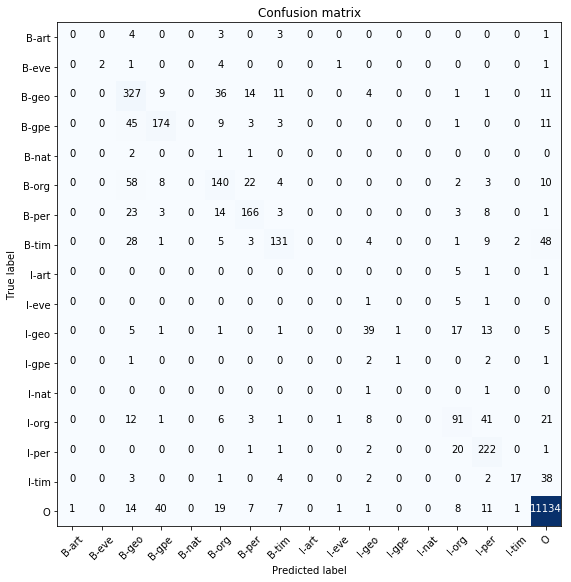

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ner_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = Tag_le.inverse_transform(list(range(17)))

plt.figure(figsize=(8,8))
plot_confusion_matrix(ner_matrix, classes=class_names, normalize=False)
plt.show()

## Discussion
- The model dose some work, but not very good, especially for those classes that have little samples. With a larger training set, it's expected to perform better
- Removing some pure noise(POS that are absolutely not named entities) from the training date may have impoved the result.
- if pre-trained word2vec model were allowed, using vector generated from it would have resulted in a better model.


- try using TF-IDF: 
need to find perameters of TF-IDF. By defaul it give too many columns, but if set min_df too high, named entities may be ignored.

In [29]:
tfidf = TfidfVectorizer(min_df=40)
tfidf_feature = tfidf.fit_transform(df['Word'])
tfidf_feature

<66161x198 sparse matrix of type '<class 'numpy.float64'>'
	with 30419 stored elements in Compressed Sparse Row format>

In [30]:
train_df['tfidf']=list(tfidf_feature)
train_df[['Tag','tfidf']]

,Tag,tfidf
0,16,
1,16,"(0, 108)\t1.0"
2,16,
3,16,"(0, 60)\t1.0"
4,16,
5,16,
6,2,
7,16,"(0, 167)\t1.0"
8,16,
9,16,"(0, 159)\t1.0"
